# Multi-Label Emotion Recognition from Text using GoEmotions Dataset

This project focuses on **Multi-Label Emotion Recognition** from textual data using the **GoEmotions** dataset developed by Google Research. The goal is to build a model capable of identifying multiple emotions (such as joy, sadness, anger, surprise, etc.) expressed in a single piece of text.

The GoEmotions dataset contains over 65,000 carefully curated English Reddit comments, each labeled with one or more of 27 fine-grained emotion categories and a neutral label. Unlike single-label classification, this task requires handling **multi-label outputs**, as human emotions are often complex and overlapping.

The project uses transformer-based models (e.g., BERT, RoBERTa) for deep contextual understanding of text, optimized with techniques like **class weighting**, **custom loss functions**, and evaluation metrics such as **Hamming Loss** and **Micro/Macro F1 Score**.

This model can be applied in real-world NLP applications such as:
- Sentiment analysis
- Chatbots
- Customer feedback analysis
- Social media monitoring


## Dataset Preparation

To streamline the development process, the GoEmotions dataset was preprocessed in advance. The following cleaning steps were performed:

- Removed unnecessary columns that were not relevant to the emotion classification task.
- Eliminated duplicate entries to avoid data redundancy and bias.
- Handled and removed any null or missing values to ensure dataset consistency.

The cleaned version of the dataset has been saved as **`testing.csv`**, which serves as the input for model training and evaluation.


## Methodology and Techniques

To address the multi-label emotion recognition task, the following techniques and tools were employed:

### 1. **Data Splitting**
The dataset was split into training and testing sets using an 90/10 ratio with a fixed random seed to ensure reproducibility. The features (`text`) and labels (28 emotion columns) were separated accordingly.

### 2. **Transformer-based Tokenization**
The **DistilBERT tokenizer** from Hugging Face's `transformers` library was used to convert raw text into token IDs. Texts were tokenized with a maximum length of 32 tokens, using padding and truncation to maintain consistency across inputs.

### 3. **TensorFlow Dataset Preparation**
Tokenized inputs and corresponding labels were wrapped into `tf.data.Dataset` objects to facilitate efficient training. The datasets were:
- Shuffled to ensure training diversity
- Batched with a size of 32
- Prefetched to improve input pipeline performance

### 4. **Model Architecture**
A custom classification model was built using **TFDistilBertModel**:
- The `[CLS]` token output was extracted from DistilBERT as the pooled representation.
- A dense output layer with 28 sigmoid-activated units was used to predict multiple emotions per input, suitable for multi-label classification.

### 5. **Training Configuration**
The model was compiled with:
- **Adam optimizer** using a learning rate of `1e-5`
- **Binary cross-entropy loss** function, appropriate for multi-label classification
- **Accuracy** as the evaluation metric

The model was trained for 3 epochs using the prepared TensorFlow datasets, with validation on the held-out test set to monitor generalization performance.


In [1]:
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, hamming_loss
import tensorflow as tf
from tensorflow.keras.metrics import AUC, Precision, Recall
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython.display import display  # Optional, for Jupyter notebook display


In [2]:
df = pd.read_csv('testing.csv')
display(df.head())

,text,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,that game hurt.,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"you do right, if you don't care then fuck 'em!",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,man i love reddit.,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,"[name] was nowhere near them, he was by the fa...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,right? considering it’s such an important docu...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Basic statistics
print("DataFrame shape:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nDescriptive statistics for numerical columns:\n", df.describe())

DataFrame shape: (68871, 29)

Data types:
 text              object
admiration         int64
amusement          int64
anger              int64
annoyance          int64
approval           int64
caring             int64
confusion          int64
curiosity          int64
desire             int64
disappointment     int64
disapproval        int64
disgust            int64
embarrassment      int64
excitement         int64
fear               int64
gratitude          int64
grief              int64
joy                int64
love               int64
nervousness        int64
optimism           int64
pride              int64
realization        int64
relief             int64
remorse            int64
sadness            int64
surprise           int64
neutral            int64
dtype: object

Descriptive statistics for numerical columns:
          admiration     amusement         anger     annoyance      approval  \
count  68871.000000  68871.000000  68871.000000  68871.000000  68871.000000   
mean       0

In [4]:
# Missing values
print("\nMissing values per column:\n", df.isnull().sum())
print("\nNumber of rows with any missing values:", df.isnull().any(axis=1).sum())
print("\nNumber of rows with all missing values:", df.isnull().all(axis=1).sum())


Missing values per column:
 text              0
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
dtype: int64

Number of rows with any missing values: 0

Number of rows with all missing values: 0



Emotion label counts:
 admiration         5647
amusement          3081
anger              2589
annoyance          4443
approval           5928
caring             1988
confusion          2471
curiosity          3267
desire             1248
disappointment     2771
disapproval        3774
disgust            1704
embarrassment       817
excitement         1900
fear               1048
gratitude          3863
grief               227
joy                2607
love               2745
nervousness         598
optimism           2887
pride               452
realization        2867
relief              452
remorse             849
sadness            2193
surprise           1806
neutral           18423
dtype: int64


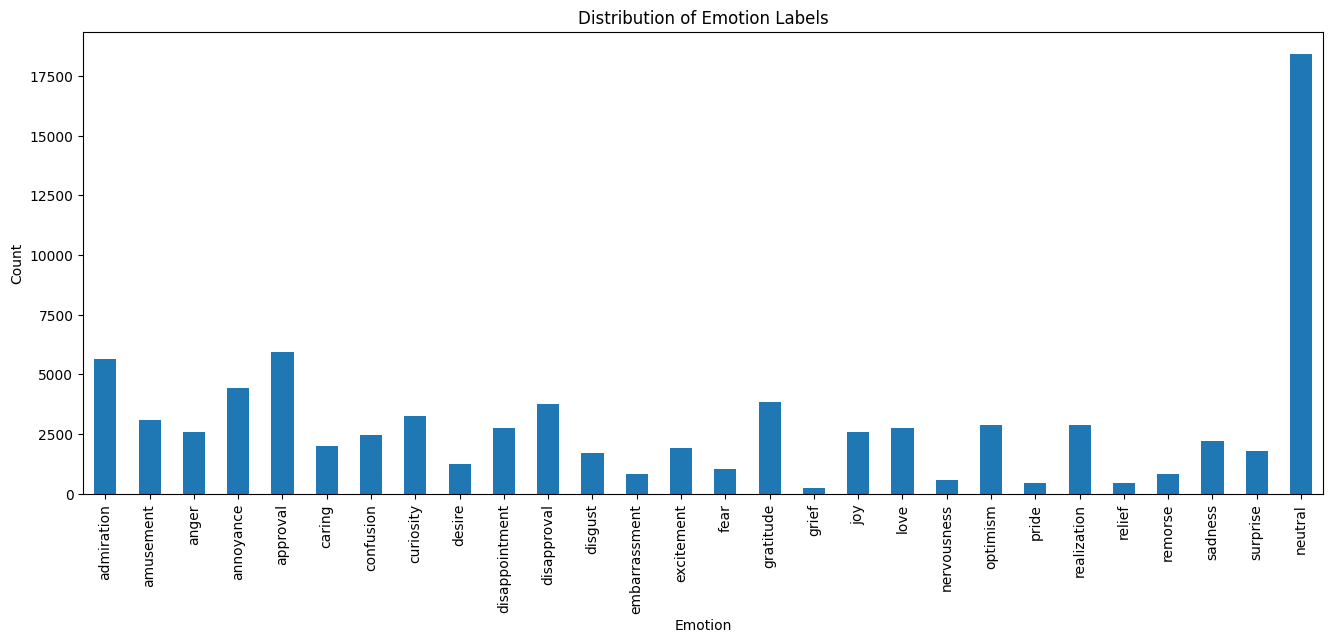

In [5]:
# Emotion label distribution
emotion_cols = df.columns[1:]  # Exclude 'id', 'text', and 'example_very_unclear'
emotion_counts = df[emotion_cols].sum()
print("\nEmotion label counts:\n", emotion_counts)

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
emotion_counts.plot(kind='bar')
plt.title('Distribution of Emotion Labels')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [6]:
emotion_cols

Index(['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
       'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
       'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
       'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
       'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [7]:
emotion_counts

,0
admiration,5647
amusement,3081
anger,2589
annoyance,4443
approval,5928
caring,1988
confusion,2471
curiosity,3267
desire,1248
disappointment,2771


In [8]:
# Unique labels
num_unique_labels = len(emotion_cols)
print(f"\nNumber of unique emotion labels: {num_unique_labels}")

# Text data examination (basic)
print("\nText column length statistics:")
print(df['text'].str.len().describe())


Number of unique emotion labels: 28

Text column length statistics:
count    68871.000000
mean        69.483367
std         36.506732
min          1.000000
25%         39.000000
50%         67.000000
75%         97.000000
max        703.000000
Name: text, dtype: float64


In [9]:
# Check for and remove duplicate rows
print(f"Number of duplicate rows before removal: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Number of duplicate rows after removal: {df.duplicated().sum()}")
df = df.reset_index(drop=True)

# Verify and handle missing values (although no missing values were found during exploration)
print("\nMissing values per column:\n", df.isnull().sum())

Number of duplicate rows before removal: 7417
Number of duplicate rows after removal: 0

Missing values per column:
 text              0
admiration        0
amusement         0
anger             0
annoyance         0
approval          0
caring            0
confusion         0
curiosity         0
desire            0
disappointment    0
disapproval       0
disgust           0
embarrassment     0
excitement        0
fear              0
gratitude         0
grief             0
joy               0
love              0
nervousness       0
optimism          0
pride             0
realization       0
relief            0
remorse           0
sadness           0
surprise          0
neutral           0
dtype: int64


In [10]:
df.columns

Index(['text', 'admiration', 'amusement', 'anger', 'annoyance', 'approval',
       'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
       'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
       'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride',
       'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

In [11]:
# Apply preprocessing and create a new DataFrame
cleaned_df = df.copy()  # Make a copy of the original DataFrame

In [12]:
# 1. Text preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)    # Remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = text.lower()  # Lowercase the text
    return text

cleaned_df['text'] = cleaned_df['text'].apply(preprocess_text)

In [13]:
cleaned_df['text']

,text
0,that game hurt.
1,"you do right, if you don't care then fuck 'em!"
2,man i love reddit.
3,"[name] was nowhere near them, he was by the fa..."
4,right? considering it’s such an important docu...
...,...
61449,"it's about fucking time, hope this is real."
61450,this is great! can anyone make a request with ...
61451,i’m sorry. can you please explain what are the...
61452,no but it should be


In [14]:
texts = df['text'].values
labels = df.iloc[:, 1:].values  # All columns except text

In [15]:
texts

array(['that game hurt.',
       "you do right, if you don't care then fuck 'em!",
       'man i love reddit.', ...,
       'i’m sorry. can you please explain what are the 2 accounts of the order of creation are contradictory?',
       'no but it should be',
       'this is so cruel. i literally feel physically sick.'],
      dtype=object)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=42)

In [17]:
from transformers import DistilBertTokenizer, TFDistilBertModel
import tensorflow as tf

# 1. Tokenizer (DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [18]:
# 2. Encode texts with max_length = 32
def encode_texts(texts, tokenizer, max_len=32):
    encodings = tokenizer(
        list(texts),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors='np'
    )
    return encodings

train_encodings = encode_texts(X_train, tokenizer)
test_encodings = encode_texts(X_test, tokenizer)

In [19]:
# 3. Convert to tf.data.Dataset with shuffle and prefetch
def create_tf_dataset(encodings, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': tf.constant(encodings['input_ids']),
            'attention_mask': tf.constant(encodings['attention_mask'])
        },
        tf.constant(labels, dtype=tf.float32)
    ))
    return dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = create_tf_dataset(train_encodings, y_train)
test_dataset = create_tf_dataset(test_encodings, y_test)

In [20]:
# 4. Create model using DistilBERT (input shape = 32)
def create_model():
    distil_bert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    input_ids = tf.keras.Input(shape=(32,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(32,), dtype=tf.int32, name="attention_mask")

    # CLS token output
    bert_output = distil_bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )[0][:, 0, :]  # shape: (batch_size, hidden_dim)

    output = tf.keras.layers.Dense(28, activation='sigmoid')(bert_output)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [21]:
# 5. Train the model
model = create_model()
history = model.fit(train_dataset, epochs=3, validation_data=test_dataset)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/3
1729/1729 [==============================] - 220s 113ms/step - loss: 0.1433 - accuracy: 0.3315 - val_loss: 0.1254 - val_accuracy: 0.3759
Epoch 2/3
1729/1729 [==============================] - 191s 111ms/step - loss: 0.1226 - accuracy: 0.3846 - val_loss: 0.1226 - val_accuracy: 0.3838
Epoch 3/3
1729/1729 [==============================] - 198s 114ms/step - loss: 0.1175 - accuracy: 0.4022 - val_loss: 0.1223 - val_accuracy: 0.3780
